# Smiths Project 

**RQ: What are the main recurring themes, emotional patterns, and linguistic characteristics present in The Smiths' lyrics, and how do these evolve and perform over their Albums?**

Steps taken:
1. **Data Collection**
   - **Objective**: Gather a comprehensive collection of The Smiths'song and Albums
   - **Challenges**: The Smiths Discography is littered with junk. Struggled with getting just thier actualy songs for a while. The only solution that worked was specifying a list of albums that I wanted to look into. 
2. **Data Cleaning and Preprocessing**
   - **Objective**: Clean and prepare the lyrics data for analysis.
3. **Data Categorization and Theme Identification**
   - **Objective**: Identify main recurring themes in The Smiths’ lyrics.
4. **Sentiment Analysis**
   - **Objective**: Determine the sentiment expressed in each song.
   - **Challenges**: Didnt really like the results of the sentiment analysis since it didnt really get the real sentiment of the songs. I lost all trust when it says a songs called 'Heaven Knows I'm Miserable Know' has a highley positive sentiment. 
5. **Visualization Setup**
   - **Objective**: Visualize the most used words and provide a complete album description.
6. **Documentation and Writeup**
   - **Objective**: Document your findings and compile the results into a comprehensive report.

In [1]:
# Import neccessary libraries

import regex as re
import lyricsgenius
import pandas as pd
import requests
import os
from dotenv import load_dotenv
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import wordcloud as WordCloud
from IPython.display import display, Image

SPOTIFY_CLIENT_ID = '8ff4939a9ed140ed9d0fa6b55b44169b'
SPOTIFY_CLIENT_SECRET = '6ae7ff9f5ac14c08bf9fe8ec6a0f25d2'
GENIUS_CLIENT_ID = 'HBEdvu8RZHXDifNxoZSXBdXSapPiYoEFigthUL3Vo0Ork1pG0PD5hxo-umZXJYcx'
GENIUS_SECRET = 'gbc3Zp4P13XThN_LirZwB4codP5jGtl5Rc8Yaxh5_eQF0ybh6sP-LNymgzmErL6Ys_R_IspR6roqd4DIiopneQ'

# Define real list of albums since most of the smiths catalog is Live albums and compilations or Movies
ALBUMS = ['The Smiths', 'Meat Is Murder', 'The Queen Is Dead', 'Strangeways, Here We Come', 'Louder Than Bombs', 'Hateful of Hallow']

/Users/eduardobenjamin/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Get access token from API's

def get_access_token(url, client_id, client_secret):
    url = url
    data = {
        'client_id': client_id,
        'client_secret': client_secret,
        'grant_type': 'client_credentials'
    }
    response = requests.post(url, data=data)
    response_data = response.json()
    if response.status_code != 200:
        print('Error:', response_data['error'])
        return None
    else:
        print('Access Token:', response_data['access_token'])
        return response_data['access_token']
    

load_dotenv('3510.env')
genius_client_id = os.getenv('GENIUS_CLIENT_ID')
genius_client_secret = os.getenv('GENIUS_SECRET')
genius_access_token = get_access_token(url='https://api.genius.com/oauth/token', client_id=genius_client_id, client_secret=genius_client_secret)

spotify_client_id = os.getenv("SPOTIFY_CLIENT_ID")
spotify_client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")

spotify_access_token = get_access_token(url='https://accounts.spotify.com/api/token', client_id=spotify_client_id, client_secret=spotify_client_secret)

Access Token: BUtflwK8yqTcDgwHvpnm2TciGsdXBbuvb0_ylBl7_HXyu7RNDNUXy5u9-aSM-D7e
Access Token: BQCKg-Z01iocI5Cm36Bnnr7QKoVGm8psVEBdeIFtI9acJAH29m5FwJxNR9-jW3tLL637bNkRRphHYoUZbsHhj2aQo-KxXqpltDnzfEkqW7jYWUG9Pr0


In [3]:
# Define the Album and Song classes

class Album:
    """ 
    This class represents an album. 

    Attributes:
    name (str): The name of the album.
    artist (str): The artist of the album.
    album_id (str): The album's unique identifier.
    release_date (str): The album's release date.
    total_tracks (int): The total number of tracks on the album.
    songs (list): A list of songs on the album.
    theme (str): The overall theme of the album.
    """
    def __init__(self, name, artist, album_id, release_date, total_tracks):
        self.name = name
        self.artist = artist
        self.album_id = album_id
        self.release_date = release_date
        self.total_tracks = total_tracks
        self.songs = []
        self.theme = None
        self.image_path = 'images/' + self.name + '.png'

    def add_song(self, song):
        """
        Add a song to the album.
        """
        self.songs.append(song)

    def description(self):
            """
            Print a description of the album.
            """
            print(f'{"-"*40}')
            print(f'{self.name} is an album by {self.artist} released on {self.release_date}.')
            print(f'It contains {len(self.songs)} tracks. The overall theme of the album is "{self.theme}".')
            print(f'{"-"*40}\n')

    def full_description(self):
        """
        Print a full description of the album and its songs.
        """
        self.description()
        
        # Display the album cover image
        display(Image(self.image_path))

        print(f'{"Tracklist":^40}')
        print(f'{"="*40}')
        
        # Format each song with its track number, name, duration, and theme
        for song in self.songs:
            print(f'Track {song.track_number}: {song.name}')
            print(f'  Duration: {song.duration}')
            print(f'  Theme: {song.theme}\n')
        
        print(f'{"="*40}')

    def word_cloud(self):
        """
        Generate a word cloud of the album's lyrics.
        """
        lyrics = ''
        for song in self.songs:
            for word in song.lyrics:
                if word not in [',',"'",'"','(',')','.',':',';','?','!',"'s","n't","``",'"',"'m","'ll","'re","'ve","''"]:
                    lyrics += word + ' '
            # elif song.lyrics and isinstance(song.lyrics, list):
            #     lyrics += ' '.join(song.lyrics) + ' '
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(lyrics)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

class Song:
    """
    This class represents a song. The song is automatically added to the album's song list when created.

    Attributes:
    album (Album): The album the song belongs to.
    name (str): The name of the song.
    artist (str): The artist of the song.
    song_id (str): The song's unique identifier.
    duration_ms (int): The duration of the song in milliseconds.
    explicit (bool): Whether the song contains explicit content.
    track_number (int): The track number of the song on the album.
    lyrics (str): The lyrics of the song.
    theme (str): The theme of the song.
    """
    def __init__(self, album, name, artist, song_id, duration_ms, explicit, track_number):
        self.album = album
        self.name = name
        self.artist = artist
        self.song_id = song_id
        self.duration_ms = duration_ms
        self.duration = pd.to_datetime(self.duration_ms, unit='ms').strftime('%M:%S')
        self.explicit = explicit
        self.track_number = track_number
        self.lyrics = None
        self.theme = None

        # Automatically add the song to the album's song list
        album.add_song(self)

In [4]:
# Get Albums from SpotifyAPI

rootURL = 'https://api.spotify.com/v1/'
headers = {"Authorization":"Bearer "+spotify_access_token}
smiths_search = requests.get(rootURL+'search?q=TheSmiths&type=artist',headers=headers).json()
smiths_id = smiths_search['artists']['items'][0]['id']
smiths_albums = requests.get(rootURL+'artists/'+smiths_id+'/albums',headers=headers).json()

In [5]:
# Assign albums and attributes to Album class

smiths_album_names = [album['name'] for album in smiths_albums['items'] if album['name'] in ALBUMS]
smiths_album_ids = [album['id'] for album in smiths_albums['items'] if album['name'] in ALBUMS]
smithAlbums = []

for i in range(len(smiths_album_names)):
    album = Album(name=smiths_album_names[i], 
                  artist='The Smiths', 
                  album_id=smiths_album_ids[i], 
                  release_date=smiths_albums['items'][i]['release_date'],
                  total_tracks=smiths_albums['items'][i]['total_tracks'])
    smithAlbums.append(album)

In [6]:
# Get songs from each album and assign to Song class
smith_songs_by_album = {}

for i in range(len(smiths_album_ids)):
    all_songs = []
    url = rootURL+'albums/'+smiths_album_ids[i]+'/tracks'
    songs = requests.get(url,headers=headers).json()
    for song in songs['items']:
        print(song)
        album = smithAlbums[i]
        song_name = song['name'].split(' - ')[0] # remove the extra info from the song name
        song_id = song['id']
        duration_ms = song['duration_ms']
        explicit = song['explicit']
        track_number = song['track_number']
        song = Song(album=album,
                    name=song_name, 
                    artist='The Smiths', 
                    song_id=song_id, 
                    duration_ms=duration_ms, 
                    explicit=explicit, 
                    track_number=track_number)
        all_songs.append(song.name)


{'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3yY2gUcIsjMr8hjo51PoJ8'}, 'href': 'https://api.spotify.com/v1/artists/3yY2gUcIsjMr8hjo51PoJ8', 'id': '3yY2gUcIsjMr8hjo51PoJ8', 'name': 'The Smiths', 'type': 'artist', 'uri': 'spotify:artist:3yY2gUcIsjMr8hjo51PoJ8'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'BY', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'BD', 'PK', 'LK', 'GH', 'KE', 'NG', 'TZ', 'UG', 'AG', 'AM', 'BS', 'BB', 'BZ', 'BT', 'BW', 'BF', 'CV', 'CW', 'DM', 'FJ', 'GM', 'GE', 'GD', '

In [9]:
# Get lyrics for each song

for i,album in enumerate(smithAlbums):
    for j,song in enumerate(album.songs):
        try:
            genius = lyricsgenius.Genius(genius_access_token)
            print("Searching for", song.name)   
            geniusSong = genius.search_song(song.name, "The Smiths")
            song.lyrics = geniusSong.lyrics
        except:
            song.lyrics = None
            print("Lyrics not found for", song.name)


Searching for A Rush and a Push and the Land Is Ours
Searching for "A Rush and a Push and the Land Is Ours" by The Smiths...
Done.
Searching for I Started Something I Couldn't Finish
Searching for "I Started Something I Couldn't Finish" by The Smiths...
Done.
Searching for Death of a Disco Dancer
Searching for "Death of a Disco Dancer" by The Smiths...
Done.
Searching for Girlfriend in a Coma
Searching for "Girlfriend in a Coma" by The Smiths...
Done.
Searching for Stop Me If You Think You've Heard This One Before
Searching for "Stop Me If You Think You've Heard This One Before" by The Smiths...
Done.
Searching for Last Night I Dreamt That Somebody Loved Me
Searching for "Last Night I Dreamt That Somebody Loved Me" by The Smiths...
Done.
Searching for Unhappy Birthday
Searching for "Unhappy Birthday" by The Smiths...
Done.
Searching for Paint a Vulgar Picture
Searching for "Paint a Vulgar Picture" by The Smiths...
Done.
Searching for Death at One's Elbow
Searching for "Death at One's E

In [10]:
# Create a DataFrame and save to CSV so I dont have to wait 8 minutes to get the data again
albums_df = pd.DataFrame(columns=['Album Name', 'Artist', 'Release Date', 'Total Tracks', 'Song Name', 'Duration (ms)', 'Explicit', 'Track Number', 'Lyrics'])
for album in smithAlbums:
    for song in album.songs:
        if song.lyrics is None:
            continue
        else:
            song_data = pd.DataFrame([[album.name, song.artist, album.release_date, album.total_tracks, song.name, song.duration_ms, song.explicit, song.track_number, song.lyrics]], columns=['Album Name', 'Artist', 'Release Date', 'Total Tracks', 'Song Name', 'Duration (ms)', 'Explicit', 'Track Number', 'Lyrics'])
            albums_df = pd.concat([albums_df, song_data], ignore_index=True)


In [11]:
# Clean up the lyrics column 
for index, row in albums_df.iterrows():
    if '[' in row['Lyrics']:
                # Split on only the first occurrence of ']' and keep only the second part
                lyrics = row['Lyrics'].split(']', 1)[1]
                # Split on only the last occurrence of '[' and keep only the first part
                lyrics = lyrics.rsplit('[', 1)[0]
                # Use regex to remove all text in brackets
                pattern = r'\[.*?\]'
                lyrics = re.sub(pattern, ' ', lyrics)

                # Alter the DataFrame
                albums_df.at[index, 'Lyrics'] = lyrics
    else: 
        # Split on only the first occurrence of 'Lyrics' and keep only the second part
        lyrics = row['Lyrics'].split('Lyrics', 1)[1]
        # Split on only the last occurrence of 'E' for Embedded and keep only the first part
        lyrics = lyrics.rsplit('E', 1)[0]
        albums_df.at[index, 'Lyrics'] = lyrics

In [12]:
# Clean lyrics column further not based on any conditions

albums_df['Lyrics'] = albums_df['Lyrics'].str.replace('\n', ' ')

# Use regex to remove descriptors in the lyrics (*applause*)
pattern = r'\*.*?\*'
albums_df['Lyrics'] = albums_df['Lyrics'].apply(lambda x: re.sub(pattern, ' ', x) if x is not None else None)

In [13]:
# Tokenize and remove stop words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


stop_words = set(stopwords.words('english'))

# Define a function to tokenize and remove stop words
def tokenize_and_remove_stopwords(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return filtered_words

# Apply the function to the 'Lyrics' column
albums_df['Tokenized Lyrics'] = albums_df['Lyrics'].apply(tokenize_and_remove_stopwords)


In [14]:
# albums_df.to_csv('smiths_albums_cleaned.csv', index=False)
# albums_df = pd.read_csv('smiths_albums_cleaned.csv')

In [15]:
# Do sentiment analysis on the lyrics

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Example of tokenized and cleaned lyrics
lyrics = albums_df['Tokenized Lyrics'][albums_df['Song Name'] == "Heaven Knows I'm Miserable Now"].tolist()[0]
print(lyrics)
# Combine tokens into a single string
lyrics_str = " ".join(lyrics)

# Get sentiment scores
sentiment = analyzer.polarity_scores(lyrics_str)

print(f"Sentiment Scores: {sentiment}")


['happy', 'haze', 'drunken', 'hour', 'heaven', 'knows', "'m", 'miserable', 'looking', 'job', 'found', 'job', 'heaven', 'knows', "'m", 'miserable', 'life', ',', 'give', 'valuable', 'time', 'people', "n't", 'care', 'live', 'die', '?', 'Two', 'lovers', 'entwined', 'pass', 'heaven', 'knows', "'m", 'miserable', 'looking', 'job', 'found', 'job', 'heaven', 'knows', "'m", 'miserable', 'life', ',', 'oh', ',', 'give', 'valuable', 'time', 'people', "n't", 'care', 'live', 'die', '?', 'asked', 'end', 'day', 'Caligula', 'would', 'blushed', '``', 'Oh', ',', "'ve", 'house', 'long', ',', "''", 'said', 'naturally', 'fled', 'might', 'also', 'like', 'life', ',', 'smile', 'people', "'d", 'much', 'rather', 'Kick', 'eye', '?', 'happy', 'haze', 'drunken', 'hour', 'heaven', 'knows', "'m", 'miserable', '``', 'Oh', ',', "'ve", 'house', 'long', ',', "''", 'said', 'naturally', 'fled']
Sentiment Scores: {'neg': 0.141, 'neu': 0.558, 'pos': 0.301, 'compound': 0.9752}


In [16]:
# Define a function to get the theme of a song

def get_theme(lyrics,themeCount=False):
    """
    Get the theme of a song based on its lyrics.
    """
    # Initialize theme counts
    themes_dict = {
        'Love': [
            'heart', 'romance', 'longing', 'desire', 'affection', 'passion', 'embrace','entwined',
            'adore', 'devotion', 'infatuation', 'kiss', 'hold', 'darling', 'beloved', 'lovers','love',
            'sweetheart','loving','loved', 'sweetness', 'caring', 'care', 'cared', 'cute', 'caring', 'caringly',
            'liked','chasing','girl','lips'
        ],
        'Death': [
            'grave', 'funeral', 'mourning', 'loss', 'farewell', 'mortality', 'passing',
            'eternal', 'heaven', 'soul', 'tomb', 'afterlife', 'grief', 'dark','die','kills',
            'death','dead','died'
        ],
        'Joy': [
            'joy', 'smile', 'delight', 'laughter', 'euphoria', 'bliss', 'cheer', 'contentment',
            'bright', 'elation', 'sun', 'shine', 'celebration', 'free','happy','happiness'
        ],
        'Sorrow': [
            'tears', 'sorrow', 'melancholy', 'despair', 'heartbreak', 'loneliness', 'grief',
            'blue', 'gloom', 'cry', 'lament', 'misery', 'cold', 'lonely', 'miserable','please',
            'sad','sadness','pain','saddest', 'alone', 'feel', 'felt','forgotten'
        ]
    }
    theme_counts = {theme: 0 for theme in themes_dict.keys()}
    for word in lyrics:
        for theme, keywords in themes_dict.items():
            if word.lower() in keywords:
                theme_counts[theme] += 1
    # Get the theme with the highest count
    theme = max(theme_counts, key=theme_counts.get)
    if theme == 'love' and theme_counts[theme] == 0:
        theme = 'neutral'
    if themeCount:
        return theme_counts
    else:
        return theme

albums_df['Theme'] = albums_df['Tokenized Lyrics'].apply(get_theme)
albums_df['Theme Count'] = albums_df['Tokenized Lyrics'].apply(lambda x: get_theme(x, themeCount=True))
albums_df['Raw Theme'] = albums_df['Lyrics'].apply(lambda x: get_theme(x.strip().split()))
albums_df['Raw Theme Count'] = albums_df['Lyrics'].apply(lambda x: get_theme(x, themeCount=True))
albums_df['Sentiment'] = albums_df['Lyrics'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
albums_df['Tokenized Sentiment'] = albums_df['Tokenized Lyrics'].apply(lambda x: analyzer.polarity_scores(" ".join(x))['compound'])

In [17]:
# Assign themes to songs in the Album class

for album in smithAlbums:
    for song in album.songs:
        try:
            song.theme = albums_df['Theme'][albums_df['Song Name'] == song.name].tolist()[0]
            song.lyrics = albums_df['Tokenized Lyrics'][albums_df['Song Name'] == song.name].tolist()[0]
            
        except:
            print('Theme not found for', song.name)
            pass
albums_df['Theme'].value_counts()

Theme not found for Oscillate Wildly


Theme
Love      32
Sorrow    15
Death     10
Joy        2
Name: count, dtype: int64

In [18]:
# Get the most common words in the lyrics

wordUsage = {}
for index, row in albums_df.iterrows():
    for word in row['Tokenized Lyrics']:
        word = word.lower()
        if word in [',',"'",'"','(',')','.',':',';','?','!',"'s","n't","``",'"',"'m","'ll","'re","'ve","''"]:
            continue
        elif word in wordUsage:
            wordUsage[word] += 1
        else:
            wordUsage[word] = 1
        
wordUsage = pd.DataFrame(wordUsage.items(), columns=['Word', 'Count'])
wordUsage = wordUsage.sort_values('Count', ascending=False)
wordUsage.head(10)

,Word,Count
91,oh,200
53,like,89
80,never,86
37,love,77
116,know,76
51,might,64
27,life,53
799,la,52
52,also,50
20,said,49


In [19]:
# Assign themes to albums in the Album class
album_theme = {}
for i,album in enumerate(albums_df['Album Name'].unique()):
    album_theme[album] = albums_df['Theme'][albums_df['Album Name'] == album].value_counts().idxmax()
    albums_df['Album Theme'] = albums_df['Album Name'].map(album_theme)
    smithAlbums[i].theme = album_theme[album]

In [20]:
albums_df.head()

,Album Name,Artist,Release Date,Total Tracks,Song Name,Duration (ms),Explicit,Track Number,Lyrics,Tokenized Lyrics,Theme,Theme Count,Raw Theme,Raw Theme Count,Sentiment,Tokenized Sentiment,Album Theme
0,"Strangeways, Here We Come",The Smiths,1988-09-05,14,A Rush and a Push and the Land Is Ours,183013,False,1,Hello I am the ghost of Troubled Joe Hung by ...,"[Hello, ghost, Troubled, Joe, Hung, pretty, wh...",Love,"{'Love': 4, 'Death': 0, 'Joy': 0, 'Sorrow': 3}",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.9943,-0.9852,Love
1,"Strangeways, Here We Come",The Smiths,1988-09-05,14,I Started Something I Couldn't Finish,227533,False,2,"The lanes were silent There was nothing, no o...","[lanes, silent, nothing, ,, one, ,, nothing, a...",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.5651,0.8180,Love
2,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Death of a Disco Dancer,326253,False,3,"The death of a disco dancer Well, it happens ...","[death, disco, dancer, Well, ,, happens, lot, ...",Love,"{'Love': 6, 'Death': 5, 'Joy': 0, 'Sorrow': 0}",Death,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",0.9986,0.9978,Love
3,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Girlfriend in a Coma,122760,False,4,"Girlfriend in a coma, I know I know, it's ser...","[Girlfriend, coma, ,, know, know, ,, 's, serio...",Sorrow,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 1}",Sorrow,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.9480,-0.9420,Love
4,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Stop Me If You Think You've Heard This One Before,215573,False,5,"Stop me, oh-oho, stop me Stop me if you think...","[Stop, ,, oh-oho, ,, stop, Stop, think, 've, h...",Love,"{'Love': 3, 'Death': 0, 'Joy': 0, 'Sorrow': 1}",Love,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",-0.9818,-0.9763,Love


In [21]:
albums_df[albums_df['Theme'] != albums_df['Raw Theme']]

,Album Name,Artist,Release Date,Total Tracks,Song Name,Duration (ms),Explicit,Track Number,Lyrics,Tokenized Lyrics,Theme,Theme Count,Raw Theme,Raw Theme Count,Sentiment,Tokenized Sentiment,Album Theme
2,"Strangeways, Here We Come",The Smiths,1988-09-05,14,Death of a Disco Dancer,326253,False,3,"The death of a disco dancer Well, it happens ...","[death, disco, dancer, Well, ,, happens, lot, ...",Love,"{'Love': 6, 'Death': 5, 'Joy': 0, 'Sorrow': 0}",Death,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",0.9986,0.9978,Love
15,The Queen Is Dead,The Smiths,1987-09-28,10,Bigmouth Strikes Again,193320,False,6,"Sweetness, sweetness I was only joking when I...","[Sweetness, ,, sweetness, joking, said, 'd, li...",Love,"{'Love': 4, 'Death': 0, 'Joy': 0, 'Sorrow': 4}",Sorrow,"{'Love': 0, 'Death': 0, 'Joy': 0, 'Sorrow': 0}",0.9042,0.9393,Love


In [22]:
# Create a bar chart of the themes

import altair as alt

theme_counts = albums_df['Raw Theme'].value_counts().reset_index()
theme_counts.columns = ['Theme', 'Count']

theme_chart = alt.Chart(theme_counts).mark_bar().encode(
    x=alt.X('Count:Q',title='Songs with Theme'),
    y=alt.Y('Theme:N', sort='-x')
).properties(
    title=alt.TitleParams('Themes in The Smiths Lyrics', 
                          subtitle='Based on the most common words in the lyrics')
).configure_title(
    fontSize=20,
    font='Courier',
    anchor='start',
    color='black'
).configure_axis(
    labelFontSize=12,
    titleFontSize=14
).configure_legend(
    titleFontSize=14,
    labelFontSize=12
).configure_view(
    strokeWidth=0
).display()


alt.Chart(...)

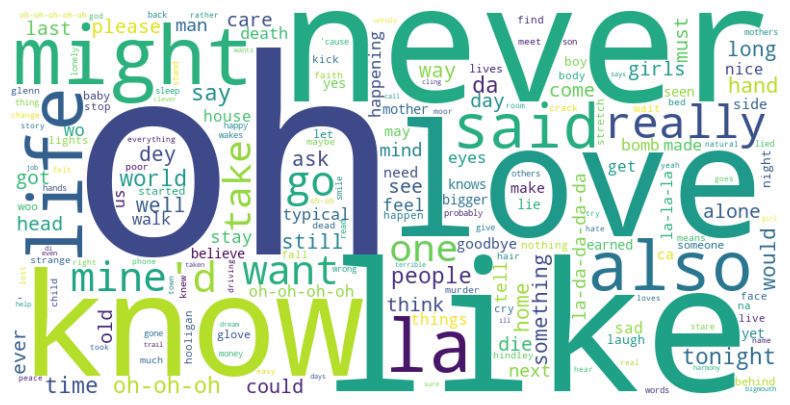

In [23]:
# Create a word cloud of the smiths lyrics

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordUsage.set_index('Word')['Count'])

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


----------------------------------------
Louder Than Bombs is an album by The Smiths released on 1985-02-11.
It contains 20 tracks. The overall theme of the album is "Love".
----------------------------------------



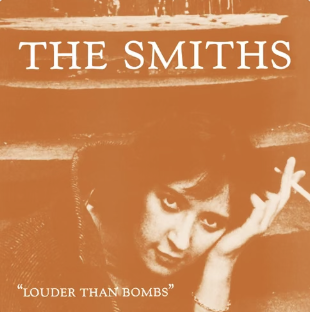

               Tracklist                
Track 1: Is It Really so Strange?
  Duration: 03:08
  Theme: Sorrow

Track 2: Sheila Take a Bow
  Duration: 02:42
  Theme: Love

Track 3: Shoplifters of the World Unite
  Duration: 02:58
  Theme: Love

Track 4: Sweet and Tender Hooligan
  Duration: 03:36
  Theme: Love

Track 5: Half a Person
  Duration: 03:38
  Theme: Love

Track 6: London
  Duration: 02:07
  Theme: Sorrow

Track 7: Panic
  Duration: 02:20
  Theme: Love

Track 8: Girl Afraid
  Duration: 02:46
  Theme: Love

Track 9: Shakespeare's Sister
  Duration: 02:08
  Theme: Love

Track 10: William, It Was Really Nothing
  Duration: 02:11
  Theme: Love

Track 11: You Just Haven't Earned It Yet, Baby
  Duration: 03:33
  Theme: Sorrow

Track 12: Heaven Knows I'm Miserable Now
  Duration: 03:35
  Theme: Death

Track 13: Ask
  Duration: 03:18
  Theme: Love

Track 14: Golden Lights
  Duration: 02:41
  Theme: Love

Track 15: Oscillate Wildly
  Duration: 03:28
  Theme: None

Track 16: These Things

In [24]:
smithAlbums[4].full_description()

In [25]:
albums_df['Release Date'] = pd.to_datetime(albums_df['Release Date'])
albums_df['Year'] = albums_df['Release Date'].dt.year

# Explode the 'Theme Count' dictionary into separate columns (e.g., Love, Death, Joy, Sorrow) CHATGPT
theme_counts_df = pd.json_normalize(albums_df['Theme Count'])
albums_df = pd.concat([albums_df, theme_counts_df], axis=1)

# Group by Year and Theme, then sum to avoid multiple values for the same theme in one year
theme_over_time = albums_df.groupby(['Year'])[['Love', 'Death', 'Joy', 'Sorrow']].sum().reset_index()

# Transform the DataFrame to a long format for easier Altair plotting MR.GPT
theme_long = theme_over_time.melt(id_vars=['Year'], value_vars=['Love', 'Death', 'Joy', 'Sorrow'],
                                  var_name='Theme', value_name='Count')

themeChart = alt.Chart(theme_long).mark_line().encode(
    x='Year:O',
    y='Count:Q',
    color='Theme:N',
    tooltip=['Year:O', 'Theme', 'Count']
).properties(
    width=700,
    height=400,
    title='Theme Count in The Smiths Albums Over Time'
)

themeChart


alt.Chart(...)